In [ ]:
tf_version = !pip3 show tensorflow | grep Version
if '2.2' not in tf_version[0]:
  print("downgrading tensorflow")
  !pip3 uninstall --yes tensorflow
  !pip3 install tensorflow==2.2

keras_version = !pip3 show keras | grep Version
if '2.3.1' not in keras_version[0]:
  print("downgrading keras")
  !pip3 uninstall --yes keras
  !pip3 install keras==2.3.1

downgrading tensorflow
Uninstalling tensorflow-2.4.0:
  Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 460kB 34.1MB/s 
     |████████████████████████████████| 3.0MB 50.4MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
downgrading keras
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 378kB 16.6MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 


In [ ]:
import nltk
nltk.download('all')
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [ ]:
from nltk.corpus import stopwords

In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt 
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing import sequence
from keras.models import load_model
from keras.layers import Embedding, Reshape
from keras.layers.merge import add
from keras.preprocessing import image
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

try:
    import dill as pickle
except ImportError:
    import pickle

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load doc into memory
def load_doc(filename): 
    file = open(filename, 'r') 
    text = file.read() 
    file.close()
    return text

base_dir = "/content/drive/My Drive/IK/"
dataset_dir = "/content/drive/My Drive/"
descriptions_filename = dataset_dir + "Flickr8k_text/Flickr8k.token.txt"
# load descriptions
descriptions_doc = load_doc(descriptions_filename)

In [ ]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        if len(line) < 2:
            continue
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping
descriptions = load_descriptions(descriptions_doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # create tokens from sentence
            desc = tokenizer.tokenize(desc)
            # make tokens lowercase
            desc = [word.lower() for word in desc]
            # filter one letter tokens
            desc = [word for word in desc if len(word)>1]
            # merge into one string
            desc_list[i] =  ' '.join(desc)
clean_descriptions(descriptions)

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def getVocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(tokenizer.tokenize(d)) for d in descriptions[key]]
    return all_desc
# summarize vocabulary
vocabulary = getVocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8464


In [ ]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        dataset.append(line)
    return (dataset)
filename = dataset_dir + 'Flickr8k_text/Flickr_8k.trainImages.txt'
train_names = load_set(filename)
print('Train size: %d' % len(train_names))
Directroy_path = dataset_dir + 'Flickr8k_Dataset/Flicker8k_Dataset/'
train_img= [Directroy_path+i  for i in train_names]

Train size: 6000


In [ ]:
# Loading test data, 
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        dataset.append(line)
    return (dataset)
filename = dataset_dir + 'Flickr8k_text/Flickr_8k.testImages.txt'
test_names = load_set(filename)
print('Test Size: %d' % len(test_names))
Directroy_path = dataset_dir + 'Flickr8k_Dataset/Flicker8k_Dataset/'
test_img= [Directroy_path+i  for i in test_names]

Test Size: 1000


In [ ]:
# we r extracting train data captions such that, each captions starts with 'startseq' and ends with 'endseq
def load_clean_descriptions(filename, dataset):
    # load document
    dataset = [i.split('.')[0] for i in dataset]
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions
# descriptions
train_descriptions = load_clean_descriptions(base_dir + 'descriptions.txt', train_names)
print('Descriptions: train=%d' % len(train_descriptions))
test_descriptions = load_clean_descriptions(base_dir + 'descriptions.txt', test_names)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: train=6000
Descriptions: test=1000


In [ ]:
# Loading Image Features
train_features = load(open(base_dir + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))
# Loading Image Features
test_features = load(open(base_dir + "encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))
# Load Train Descriptions, which contains, 5 captions corresponding to a key
train_descriptions = load(open(base_dir + "train_descriptions.pkl", "rb"))
print('Photos: train=%d' % len(train_descriptions))
test_descriptions = load(open(base_dir + "test_descriptions.pkl", "rb"))
print('Photos: test=%d' % len(test_descriptions))

Photos: train=6000
Photos: test=1000
Photos: train=6000
Photos: test=1000


In [ ]:
# Create a list of all the training captions
train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        train_captions.append(cap)
len(train_captions)

30000

In [ ]:
threshold = 7
word_counts = {}
nsents = 0
for sent in train_captions:
    nsents += 1
    for w in sent.split(' '):
        if w not in word_counts:
            word_counts[w] = 0
        word_counts[w] += 1
vocab = [w for w in word_counts if word_counts[w] >= threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7350 -> 2063


In [ ]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2064

In [ ]:
# Load Glove vectors, which contains vectors(200 Dimension) corresponding to words. 
glove_dir = '/content/drive/My Drive/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'Kopia glove.6B.200d.txt'), encoding="utf-8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Found 400000 word vectors.


In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tqdm(wordtoix.items()):
    if word in embeddings_index:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
with open(base_dir + 'Embedding_Matrix.pkl', 'wb') as embedding_pickle:
    pickle.dump(embedding_matrix, embedding_pickle)

In [ ]:
with open(base_dir + 'wordtoix.pkl', 'wb') as wti_pickle:
    pickle.dump(wordtoix, wti_pickle)

In [ ]:
# Loading Image Features
train_features = load(open(base_dir + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
# Loading embedding_matrix
embedding_matrix = load(open(base_dir + "Embedding_Matrix.pkl", "rb"))
print('Embedding Matrix shape = (%d, %d)' % (embedding_matrix.shape))

Embedding Matrix shape = (2064, 200)


In [ ]:
# Loading wordtoix
wordtoix = load(open(base_dir + "wordtoix.pkl", "rb"))
print('Wordtoix Length = %d' % len(wordtoix))

Wordtoix Length = 2063


In [ ]:
model = load_model(base_dir + 'model_39.h5')

In [ ]:
with open(base_dir + "encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
with open(base_dir + "encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = load(encoded_pickle)

In [ ]:
ixtoword = {}
for word, i in wordtoix.items():
    ixtoword[i] = word

In [ ]:
Directory_path = dataset_dir + 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
max_length = 35

In [ ]:
en_stops = set(stopwords.words('english'))

In [ ]:
porter = PorterStemmer()
lancaster=LancasterStemmer()
lemma=WordNetLemmatizer()
#BOW dla pojedynczego obrazka treningowego, jest to worek słów
def bow_words(image,encoding, sentence):
  pic = list(encoding.keys())[image]
  actual=descriptions[pic.split('.')[0]]
  word_counts = []
  if sentence == 'sentences': #dla zdań z worka uczącego
    for sent in actual:
      for w in sent.split(' '):
        w=lemma.lemmatize(w)
        w=porter.stem(w)
        if w not in word_counts:
          if w not in en_stops:
            word_counts.append(w)
  elif sentence == 'sentence': #dla przewidzianego zdania
    image = encoding[pic].reshape((1,2048))
    predicted = greedySearch(image)
    for w in predicted.split(' '):
      w=lemma.lemmatize(w)
      w=porter.stem(w)
      if w not in word_counts:
        if w not in en_stops:
          word_counts.append(w)
  return word_counts

In [ ]:
#BOW dla zbioru treningowego
train=[]
for i in range(len(encoding_train)):
  bow1=bow_words(i, encoding_train, 'sentences')
  train.append(bow1)

In [ ]:
word_cloud_train=[]
for i in train:
  for x in i:
    word_cloud_train.append(x)
word_cloud_train=pd.DataFrame(word_cloud_train, index=None, columns=None)

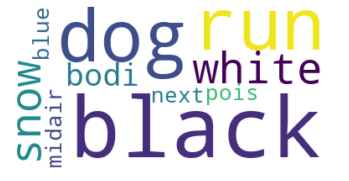

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.update(["columns", "rows"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(str(word_cloud_train))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
from operator import itemgetter 

In [ ]:
def percentage_bow(images, encoding): #wartość dla konkretnego obrazka, wartości predykcji
  pic = list(encoding.keys())[images]
  actual=descriptions[pic.split('.')[0]]
  pred=bow_words(images,encoding, sentence='sentence')
  word_counts = []
  for sent in actual:
    for w in sent.split(' '):
      w=lemma.lemmatize(w)
      w=porter.stem(w)
      if w not in en_stops:
        if w not in word_counts:
          word_counts.append(w)
  licznik=0
  for x in pred:
    if x in word_counts:
      licznik+=1
  return licznik/len(pred)

In [ ]:
def best_image_bow(image, encoding):
  pred=bow_words(image, encoding, 'sentence')
  output_train=[]
  indeks = []
  for i in range(len(encoding)):
    licznik=0
    for x in pred:
      if encoding == encoding_train:
        if x in train[i]:
          licznik+=1
      elif encoding == encoding_test:
        if x in test[i]:
          licznik+=1
    out=licznik/len(pred)
    output_train.append(out)
    indeks.append((i,out))
  wartosc=np.max(output_train)
  max_idx = max(indeks, key=itemgetter(1))[0]
  return output_train, wartosc, max_idx #wartosci predykcji i maks wartosc i numer indeksu max wartości

In [ ]:
from nltk.probability import FreqDist

In [ ]:
#dla zbioru treningowego
def bow_max_index_probability(encoding):
  bow_train_all = 0
  good = [] #worki ze zbiorów uczacych, dla obrazów przewidzianych poprawnie
  wrong_worki_uczace = [] #worki ze zbiorów uczacych, dla obrazów przewidzianych źle
  wrong_worki_najlepsze = [] ##worki ze zbiorów obrazków najlepszych, dla obrazów przewidzianych źle
  pred_good = [] #worki dla zdań przewidzianych poprawnie
  pred_wrong = [] #worki dla zdań przewidzianych źle
  values=[]
  val=0
  for i in range(len(encoding)):
    val_i=percentage_bow(i, encoding)
    output_train, image_val, indeks=best_image_bow(i, encoding)
    _, value_max,_=best_image_bow(indeks, encoding)
    pred=bow_words(i, encoding, 'sentence')
    if round(value_max,2) == round(image_val,2):
      bow_train_all = bow_train_all+1
      if encoding == encoding_train:
        for x in train[i]:
          good.append(x)
        for x in pred:
          pred_good.append(x)
      elif encoding == encoding_test:
        for x in test[i]:
          good.append(x)
        for x in pred:
          pred_good.append(x)
    else:
      if encoding == encoding_train:
        for x in train[indeks]:
          wrong_worki_najlepsze.append(x)
        for x in train[i]:
          wrong_worki_uczace.append(x)
        for x in pred:
          pred_wrong.append(x)
      elif encoding == encoding_test:
        for x in test[indeks]:
          wrong_worki_najlepsze.append(x)
        for x in test[i]:
          wrong_worki_uczace.append(x)
        for x in pred:
          pred_wrong.append(x)

      #posortowana lista wartości predykcji
      for j in output_train:
        if j not in values:
          values.append(j)
      for x, y in enumerate(sorted(values, reverse=True)): 
        if y == val_i:
          if y>= 0.5 and x <= (0.3*len(values)): #dodanie jako poprawnych, jesli indeks jest w 30% najlepszych wyników wartości i wartosc wieksza= 0.5
            val+=1
  answer_train = (bow_train_all+val)/(len(encoding))
  return good, pred_good, wrong_worki_najlepsze, wrong_worki_uczace, pred_wrong, answer_train

In [ ]:
#good = [] #worki ze zbiorów uczacych, dla obrazów przewidzianych poprawnie
#wrong_worki_uczace = [] #worki ze zbiorów uczacych, dla obrazów przewidzianych źle
#wrong_worki_najlepsze = [] ##worki ze zbiorów obrazków najlepszych, dla obrazów przewidzianych źle
#pred_good = [] #worki dla zdań przewidzianych poprawnie
#pred_wrong = [] #worki dla zdań przewidzianych źle
good, pred_good, wrong_worki_najlepsze, wrong_worki_uczace, pred_wrong, answer_train = bow_max_index_probability(encoding_train)

In [ ]:
print('Dopasowanie najlepszego zbioru do zbioru trenującego', answer_train)

<FreqDist with 561 samples and 11909 outcomes>


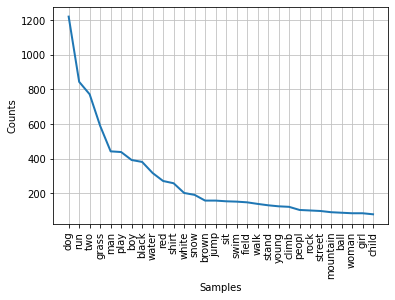

[('dog', 1220),
 ('run', 844),
 ('two', 772),
 ('grass', 590),
 ('man', 443),
 ('play', 439),
 ('boy', 393),
 ('black', 382),
 ('water', 318),
 ('red', 272)]

In [ ]:
#zdania przewidziane poprawnie
fdist = FreqDist(pred_good)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 3006 samples and 43716 outcomes>


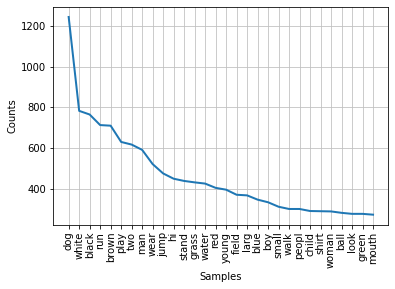

[('dog', 1245),
 ('white', 783),
 ('black', 765),
 ('run', 713),
 ('brown', 710),
 ('play', 630),
 ('two', 617),
 ('man', 591),
 ('wear', 521),
 ('jump', 475)]

In [ ]:
#worki dla zdań przewidzianych poprawnie
fdist = FreqDist(good)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 847 samples and 19687 outcomes>


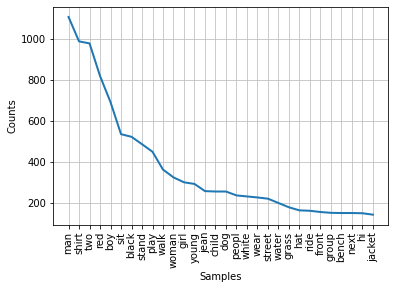

[('man', 1106),
 ('shirt', 987),
 ('two', 977),
 ('red', 818),
 ('boy', 690),
 ('sit', 534),
 ('black', 521),
 ('stand', 485),
 ('play', 448),
 ('walk', 361)]

In [ ]:
#zdania przewidziane źle
fdist = FreqDist(pred_wrong)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 2269 samples and 69397 outcomes>


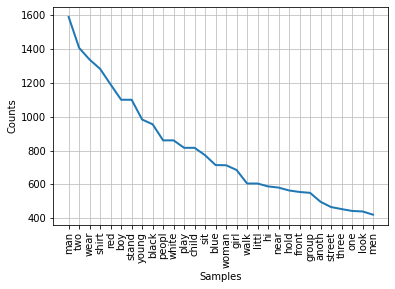

[('man', 1589),
 ('two', 1406),
 ('wear', 1337),
 ('shirt', 1282),
 ('red', 1190),
 ('boy', 1100),
 ('stand', 1100),
 ('young', 983),
 ('black', 955),
 ('peopl', 860)]

In [ ]:
#worki dla zdań przewidzianych źle, najlepsze
fdist = FreqDist(wrong_worki_najlepsze)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 4144 samples and 63603 outcomes>


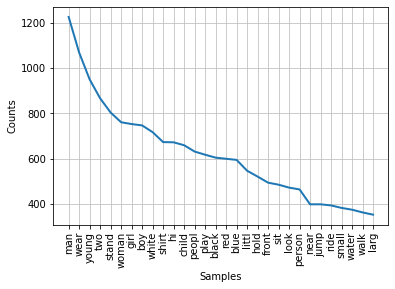

[('man', 1228),
 ('wear', 1070),
 ('young', 951),
 ('two', 867),
 ('stand', 804),
 ('woman', 761),
 ('girl', 753),
 ('boy', 747),
 ('white', 717),
 ('shirt', 673)]

In [ ]:
#worki dla zdań przewidzianych źle, uczące
fdist = FreqDist(wrong_worki_uczace)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

In [ ]:
all_train=[]
for idx in range(len(encoding_train)):
  all_train.append(percentage_bow(idx, encoding_train))
q=np.mean(all_train)
print('Średnia wartość BOW dla zbioru treningowego',q)

Średnia wartość BOW dla zbioru treningowego 0.46224704184704185


In [ ]:
#BOW dla zbioru testowego
test=[]
for i in range(len(encoding_test)):
  bow1=bow_words(i, encoding_test, 'sentences')
  test.append(bow1)

In [ ]:
word_cloud_test=[]
for i in test:
  for x in i:
    word_cloud_test.append(x)
word_cloud_test=pd.DataFrame(word_cloud_test, index=None, columns=None)

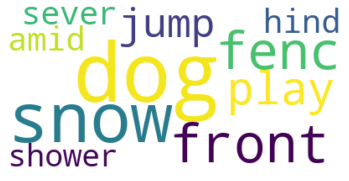

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.update(["columns", "rows"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(str(word_cloud_test))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [108]:
good_test, pred_good_test, wrong_worki_najlepsze_test, wrong_worki_uczace_test, pred_wrong_test, answer_test = bow_max_index_probability(encoding_test)

In [109]:
print('Dopasowanie najlepszego zbioru do zbioru testowego', answer_test)

Dopasowanie najlepszego zbioru do zbioru testowego 0.355


<FreqDist with 206 samples and 1239 outcomes>


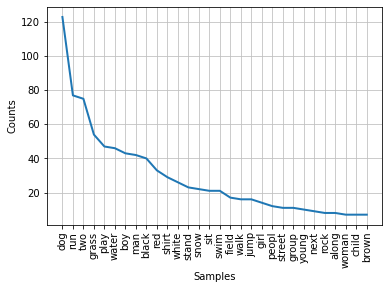

[('dog', 123),
 ('run', 77),
 ('two', 75),
 ('grass', 54),
 ('play', 47),
 ('water', 46),
 ('boy', 43),
 ('man', 42),
 ('black', 40),
 ('red', 33)]

In [ ]:
#zdania przewidziane poprawnie
fdist = FreqDist(pred_good_test)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 1054 samples and 4485 outcomes>


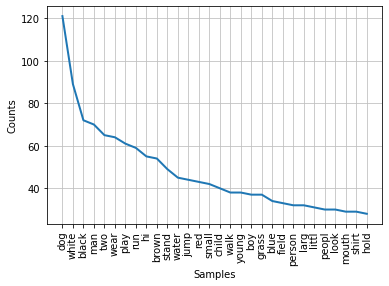

[('dog', 121),
 ('white', 89),
 ('black', 72),
 ('man', 70),
 ('two', 65),
 ('wear', 64),
 ('play', 61),
 ('run', 59),
 ('hi', 55),
 ('brown', 54)]

In [ ]:
#worki dla zdań przewidzianych poprawnie
fdist = FreqDist(good_test)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 483 samples and 4047 outcomes>


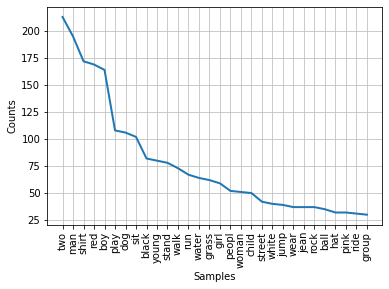

[('two', 213),
 ('man', 195),
 ('shirt', 172),
 ('red', 169),
 ('boy', 164),
 ('play', 108),
 ('dog', 106),
 ('sit', 102),
 ('black', 82),
 ('young', 80)]

In [ ]:
#zdania przewidziane źle
fdist = FreqDist(pred_wrong_test)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 1092 samples and 14729 outcomes>


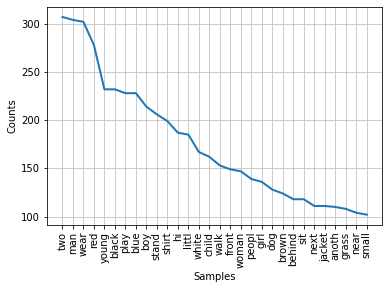

[('two', 307),
 ('man', 304),
 ('wear', 302),
 ('red', 278),
 ('young', 232),
 ('black', 232),
 ('play', 228),
 ('blue', 228),
 ('boy', 214),
 ('stand', 206)]

In [ ]:
#worki dla zdań przewidzianych źle, najlepsze
fdist = FreqDist(wrong_worki_najlepsze_test)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 1949 samples and 13458 outcomes>


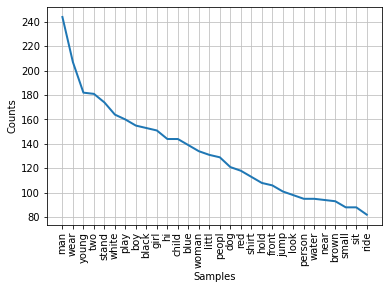

[('man', 244),
 ('wear', 207),
 ('young', 182),
 ('two', 181),
 ('stand', 174),
 ('white', 164),
 ('play', 160),
 ('boy', 155),
 ('black', 153),
 ('girl', 151)]

In [ ]:
#worki dla zdań przewidzianych źle, uczące
fdist = FreqDist(wrong_worki_uczace_test)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

In [ ]:
all_test=[]
for idx in range(len(encoding_test)):
  all_test.append(percentage_bow(idx, encoding_test))
q=np.mean(all_test)
print('Średnia wartość BOW dla zbioru testowego', q)

Średnia wartość BOW dla zbioru testowego 0.40121875901875903


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
def evaluate_bleu(photos, descriptions):
	actual, predicted = list(), list()
	# step over the whole set
	for key, features in photos.items():
		# generate description
		yhat = greedySearch(features.reshape((1,2048)))
		# store actual and predicted
		descriptions_key = key.split('.')[0]
		references = [d.split() for d in descriptions.get(descriptions_key)]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [110]:
evaluate_bleu(encoding_train,descriptions)

BLEU-1: 0.482826
BLEU-2: 0.305243
BLEU-3: 0.228981
BLEU-4: 0.123858


In [ ]:
evaluate_bleu(encoding_test,descriptions)

BLEU-1: 0.436436
BLEU-2: 0.260618
BLEU-3: 0.189073
BLEU-4: 0.089414
